# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [6]:
# Install the required libraries
!pip install prophet

In [7]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [10]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    parse_dates=['Date'], 
    index_col='Date'       
).dropna()


# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

/var/folders/9t/_vjv4_ms7kv9t_1rd71n1m5r0000gn/T/ipykernel_89915/1574378542.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [14]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


In [32]:

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

df = df.dropna(subset=['Date'])

# Slice the DataFrame for May 2020
df_may_2020 = df[(df['Date'] >= '2020-05-01') & (df['Date'] < '2020-06-01')]


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [42]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
print("Total search traffic for May 2020:", traffic_may_2020)

Total search traffic for May 2020: 38181


In [48]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
df.index = pd.to_datetime(df.index)
monthly_sum = df.groupby([df.index.year, df.index.month])['Search Trends'].sum()
median_monthly_traffic = monthly_sum.median()

# View the median_monthly_traffic value
print("Median monthly search traffic across all months:", median_monthly_traffic)

Median monthly search traffic across all months: 1785865.0


In [ ]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

Search Trends    1.085536
dtype: float64

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

In [64]:

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')


df = df.dropna(subset=['Date'])


df.set_index('Date', inplace=True)
df['DayOfWeek'] = df.index.day_name()  # Extracts day name (e.g., Monday)
df['Hour'] = df.index.hour  # Extracts hour


average_traffic = df.groupby(['DayOfWeek', 'Hour'])['Search Trends'].mean().unstack()


days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_traffic = average_traffic.reindex(days_order)


plt.figure(figsize=(12, 8))
for day in days_order:
    plt.plot(average_traffic.columns, average_traffic.loc[day], label=day)

plt.title('Average Hourly Search Traffic by Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Average Search Traffic')
plt.legend(title='Day of Week')
plt.grid(True)
plt.xticks(range(0, 24))  # Set x-ticks to represent each hour
plt.tight_layout()





KeyError: 'Date'

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

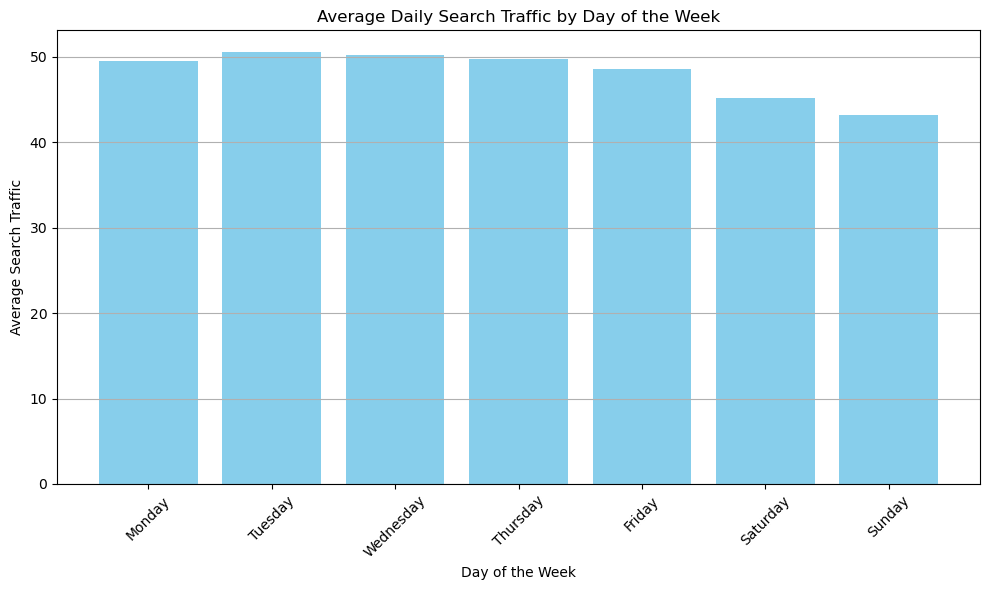

In [62]:

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')


df = df.dropna(subset=['Date'])

df.set_index('Date', inplace=True)
df['DayOfWeek'] = df.index.day_name()  


average_traffic_by_day = df.groupby('DayOfWeek')['Search Trends'].mean()


days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_traffic_by_day = average_traffic_by_day.reindex(days_order)


plt.figure(figsize=(10, 6))
plt.bar(average_traffic_by_day.index, average_traffic_by_day, color='skyblue')
plt.title('Average Daily Search Traffic by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Search Traffic')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

In [68]:

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')


df = df.dropna(subset=['Date'])


df.set_index('Date', inplace=True)
# Extract the week of the year from the index
df['WeekOfYear'] = df.index.isocalendar().week


average_traffic_by_week = df.groupby('WeekOfYear')['Search Trends'].mean()


plt.figure(figsize=(12, 6))
plt.plot(average_traffic_by_week.index, average_traffic_by_week, marker='o', linestyle='-')
plt.title('Average Hourly Search Traffic by Week of the Year')
plt.xlabel('Week of the Year')
plt.ylabel('Average Search Traffic')
plt.grid(True)
plt.tight_layout()


plt.show()


KeyError: 'Date'

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [74]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


First five rows:


,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


Last five rows:


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


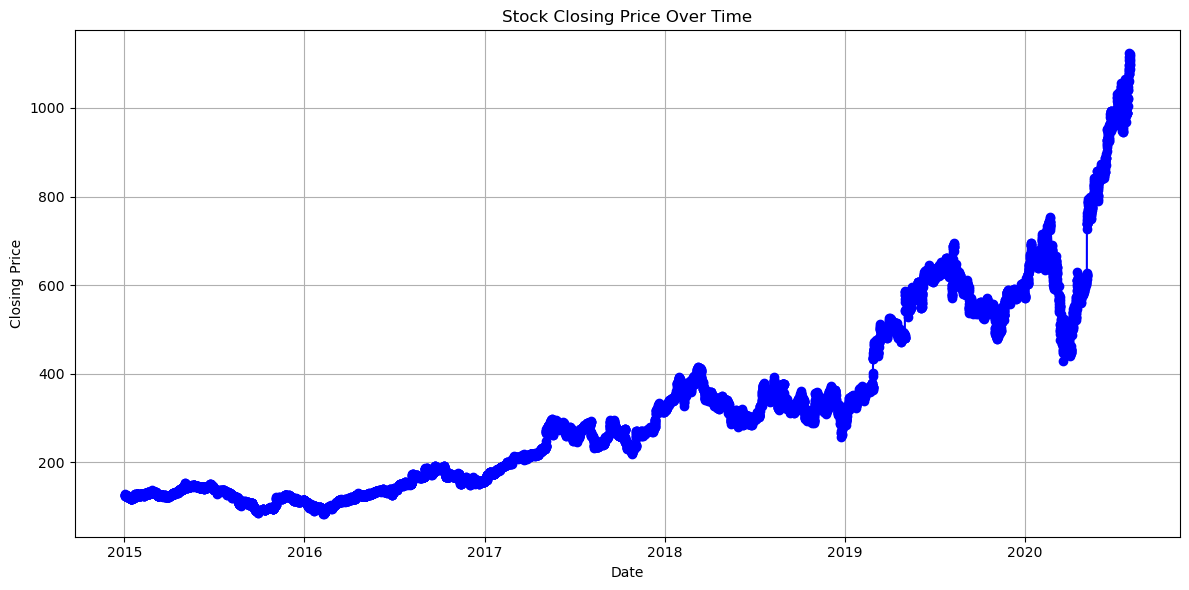

In [76]:


plt.figure(figsize=(12, 6))
plt.plot(df_mercado_stock.index, df_mercado_stock['close'], marker='o', linestyle='-', color='b')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.tight_layout()


plt.show()

In [78]:
# Concatenate the DataFrames by columns
df_combined = pd.concat([df_mercado_stock, df_mercado_trends], axis=1)

# Drop rows where only one of the DataFrames has data
df_combined = df_combined.dropna(how='any')

# Display the first and last five rows of the combined DataFrame
print("First five rows:")
display(df_combined.head())

print("Last five rows:")
display(df_combined.tail())



First five rows:


,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


Last five rows:


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [80]:


df_combined = pd.concat([df_mercado_stock, df_mercado_trends], axis=1)


df_combined = df_combined.dropna(how='any')


first_half_2020 = df_combined.loc['2020-01-01':'2020-06-30']


print("First five rows of first_half_2020:")
display(first_half_2020.head())

print("Last five rows of first_half_2020:")
display(first_half_2020.tail())

First five rows of first_half_2020:


,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


Last five rows of first_half_2020:


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


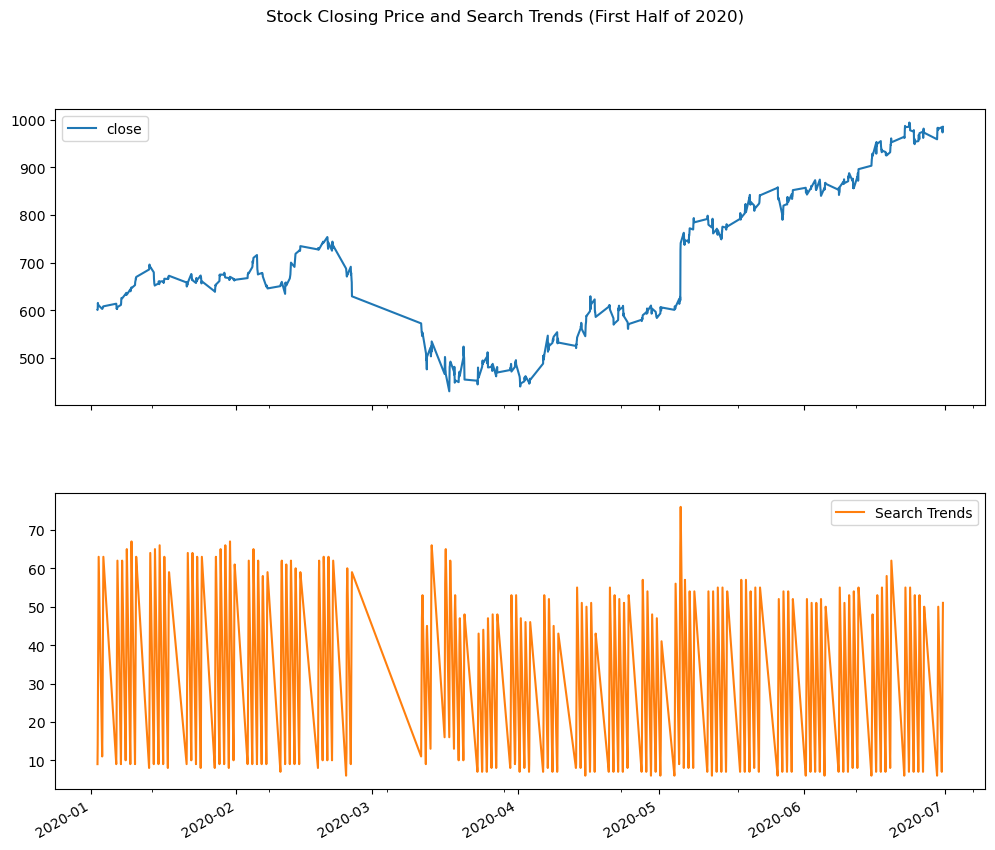

In [82]:

first_half_2020.plot(subplots=True, figsize=(12, 10), layout=(2, 1), sharex=True)


plt.suptitle('Stock Closing Price and Search Trends (First Half of 2020)')
plt.subplots_adjust(hspace=0.3)  # Adjust space between plots


plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [84]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour

mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['search_trends'].shift(1)

print("First five rows:")
display(mercado_stock_trends_df.head())

print("Last five rows:")
display(mercado_stock_trends_df.tail())

NameError: name 'mercado_stock_trends_df' is not defined

In [86]:
# Calculate the returns from the 'close' column
mercado_stock_trends_df['Returns'] = mercado_stock_trends_df['close'].pct_change()

# Calculate the rolling standard deviation of returns with a window of 4 periods
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['Returns'].rolling(window=4).std()

# Drop rows with NaN values (which will be present for the first few rows due to the rolling window)
mercado_stock_trends_df = mercado_stock_trends_df.dropna()

# Display the first and last five rows to check the new column
print("First five rows:")
display(mercado_stock_trends_df.head())

print("Last five rows:")
display(mercado_stock_trends_df.tail())

NameError: name 'mercado_stock_trends_df' is not defined

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(mercado_stock_trends_df.index, mercado_stock_trends_df['Stock Volatility'], color='r', linestyle='-', marker='o')
plt.title('Stock Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Volatility')
plt.grid(True)
plt.tight_layout()

plt.show()



NameError: name 'mercado_stock_trends_df' is not defined

<Figure size 1200x600 with 0 Axes>

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

mercado_stock_trends_df = mercado_stock_trends_df.sort_index()

mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change() * 100

mercado_stock_trends_df = mercado_stock_trends_df.dropna()

print("First five rows:")
display(mercado_stock_trends_df.head())

print("Last five rows:")
display(mercado_stock_trends_df.tail())

In [ ]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [ ]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [ ]:
df_mercado_trends_reset = df_mercado_trends.reset_index()

df_mercado_trends_reset.columns = ['ds', 'y']

df_mercado_trends_clean = df_mercado_trends_reset.dropna()

print("First five rows of the prepared DataFrame:")
display(df_mercado_trends_clean.head())

print("Last five rows of the prepared DataFrame:")
display(df_mercado_trends_clean.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [ ]:
# Call the Prophet function, store as an object
model = Prophet()

model.fit(df_mercado_trends_clean)

print("Prophet model object created and fitted.")

In [ ]:

model.fit(df_mercado_trends_clean)

print("Prophet model fitted successfully.")es model.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi4kzua4v/947z_5gs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi4kzua4v/s3y_2bzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80278', 'data', 'file=/tmp/tmpi4kzua4v/947z_5gs.json', 'init=/tmp/tmpi4kzua4v/s3y_2bzt.json', 'output', 'file=/tmp/tmpi4kzua4v/prophet_model9pwhgaux/prophet_model-20240408214021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
model = Prophet()

model.fit(df_mercado_trends_clean)

future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

print("Last five rows of the future DataFrame:")
print(future_mercado_trends.tail())

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [ ]:
model = Prophet()

model.fit(df_mercado_trends_clean)

future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

forecast_mercado_trends = model.predict(future_mercado_trends)

print("First five rows of the forecast DataFrame:")
print(forecast_mercado_trends.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,80.657755,98.092527,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,77.585016,94.403906,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.254855,83.562064,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,52.594834,69.279039,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,34.860822,51.829818,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

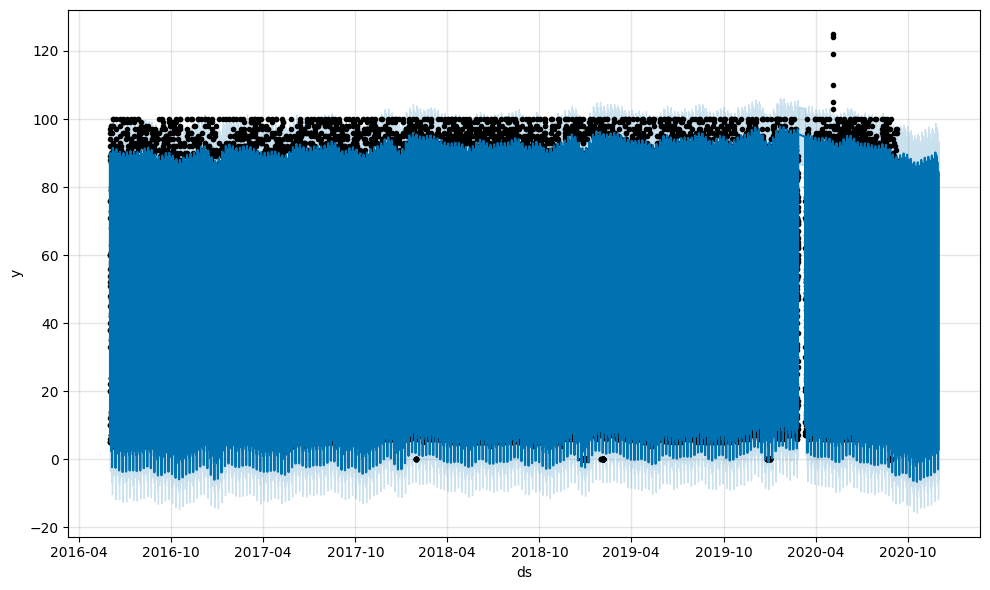

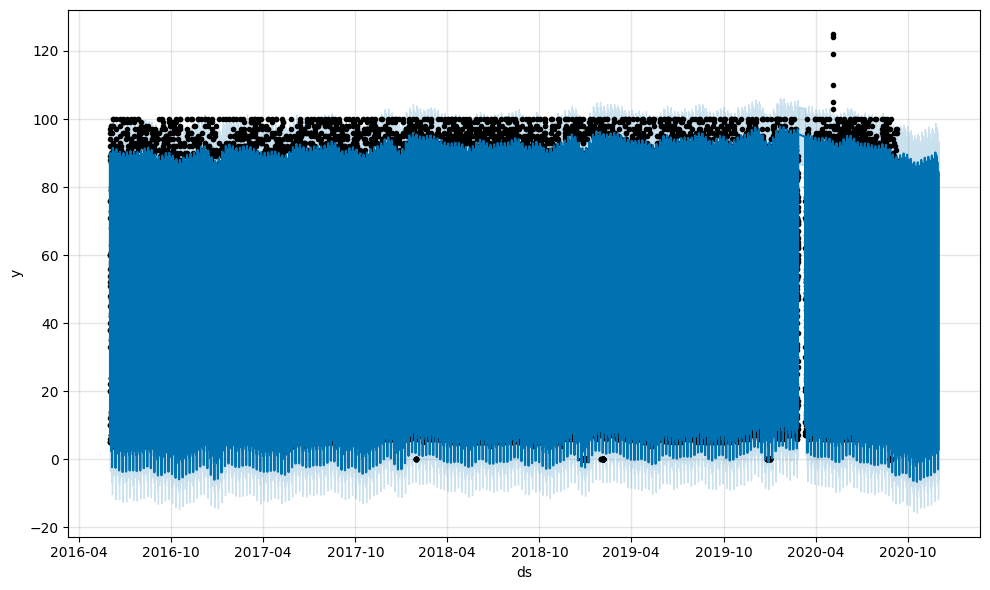

In [ ]:
model = Prophet()

model.fit(df_mercado_trends_clean)

future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

forecast_mercado_trends = model.predict(future_mercado_trends)
fig = model.plot(forecast_mercado_trends)

plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**


In [ ]:
model.fit(df_mercado_trends_clean)

future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')
forecast_mercado_trends = model.predict(future_mercado_trends)

forecast_mercado_trends.set_index('ds', inplace=True)

forecast_subset = forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]

print("First five rows of the subset DataFrame:")
print(forecast_subset.head())

,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.629222,80.657755,98.092527
2016-06-01 01:00:00,86.075935,77.585016,94.403906
2016-06-01 02:00:00,75.753361,67.254855,83.562064
2016-06-01 03:00:00,60.487045,52.594834,69.279039
2016-06-01 04:00:00,43.373051,34.860822,51.829818


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

<Axes: xlabel='ds'>

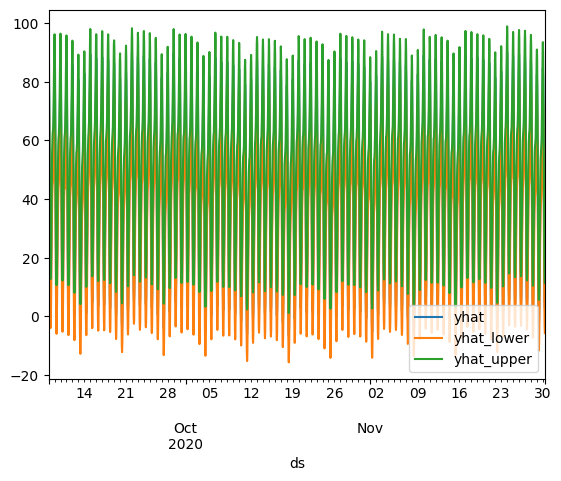

In [ ]:
model.fit(df_mercado_trends_clean)

future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

forecast_mercado_trends = model.predict(future_mercado_trends)

forecast_mercado_trends.set_index('ds', inplace=True)

forecast_last_2000_hours = forecast_mercado_trends.iloc[-2000:]

plt.figure(figsize=(12, 6))
plt.plot(forecast_last_2000_hours.index, forecast_last_2000_hours['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast_last_2000_hours.index, 
                 forecast_last_2000_hours['yhat_lower'], 
                 forecast_last_2000_hours['yhat_upper'], 
                 color='blue', alpha=0.3, label='Uncertainty Interval')

plt.title('Prophet Forecast with Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
model.fit(df_mercado_trends_clean)

future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

forecast_mercado_trends = model.predict(future_mercado_trends)

forecast_mercado_trends_reset = forecast_mercado_trends.reset_index()

fig = model.plot_components(forecast_mercado_trends)

plt.show()

NameError: name 'model' is not defined

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:**

**Question:** Which day of week gets the most search traffic?
   
**Answer:**

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**
